# Nanopore and Helicos d3pendr analysis

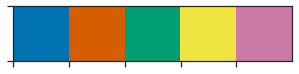

In [1]:
import sys
import re
import os
from glob import glob
import random
from collections import defaultdict

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib_venn as vn
from matplotlib.colors import ListedColormap
import seaborn as sns

from upsetplot import plot as upsetplot, from_contents

## Default plotting params

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=1.4, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])
cmap = ListedColormap(pal.as_hex())
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

In [2]:
D3PENDR_RESULTS_COLUMNS = [
    'chrom', 'start', 'end', 'locus_id', 'score', 'strand',
    'wass_dist', 'wass_dir', 'wass_pval', 'wass_fdr',
    'nreads_cntrl', 'nreads_treat'
]

In [3]:
def plot_reciprocal_histograms(datasets, labels, ranges):
    fig, axes = plt.subplots(figsize=(10, 5), ncols=2, sharey=True)
    ax_it = zip(
        axes,
        datasets,
        ranges,
        labels,
    )
    for ax, df, range_, title in ax_it:
        sig = df.query('wass_fdr < 0.05 & wass_dist > 25')
        ax.hist(sig.wass_dir, bins=30, range=range_)
        ax.axvline(0, ls='--', color='#252525')
        ax.axvspan(range_[0], 0, color=pal[1], zorder=0, alpha=0.3)
        ax.axvspan(0, range_[1], color=pal[2], zorder=0, alpha=0.3)
        ax.set_xlim(*range_)

        n_prox = len(sig.query('wass_dir < 0'))
        n_dist = len(sig.query('wass_dir > 0'))

        ax.annotate(
            xy=(0.03, 0.89),
            s=f'n={n_prox}',
            xycoords='axes fraction'
        )
        ax.annotate(
            xy=(0.97, 0.89),
            s=f'n={n_dist}',
            ha='right',
            xycoords='axes fraction',
        )
        ax.set_xlabel('Change in mean 3\' position')
        ax.set_ylabel('')
        ax.set_title(title)
    axes[0].set_ylabel('Genes (frequency)')
    plt.tight_layout()
    return axes

def plot_reciprocal_effect_sizes(datasets, labels):
    fig, axes = plt.subplots(figsize=(6, 5), ncols=2, sharey=True)

    sns.swarmplot(
        x=datasets[0].query('wass_fdr < 0.05 & wass_dist > 25').wass_dir > 0,
        y=datasets[0].query('wass_fdr < 0.05 & wass_dist > 25').wass_dist,
        ax=axes[0],
        palette=pal[1:3]
    )

    sns.swarmplot(
        x=datasets[1].query('wass_fdr < 0.05 & wass_dist > 25').wass_dir > 0,
        y=datasets[1].query('wass_fdr < 0.05 & wass_dist > 25').wass_dist,
        ax=axes[1],
        palette=pal[1:3]
    )
    axes[0].set_title(labels[0])
    axes[1].set_title(labels[1])
    #axes[0].set_ylim(-50, 1100)
    axes[0].set_ylabel('Effect size (EMD)')
    axes[1].set_ylabel('')
    axes[0].set_xticklabels(['Proximal', 'Distal'])
    axes[1].set_xticklabels(['Proximal', 'Distal'])
    axes[0].set_xlabel('APA direction')
    axes[1].set_xlabel('APA direction')
    return axes

## Nanopore DRS results:

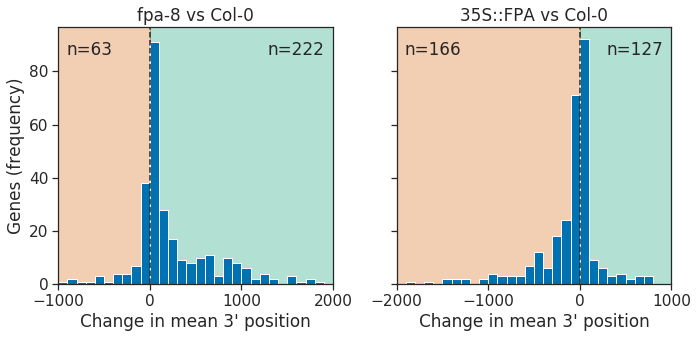

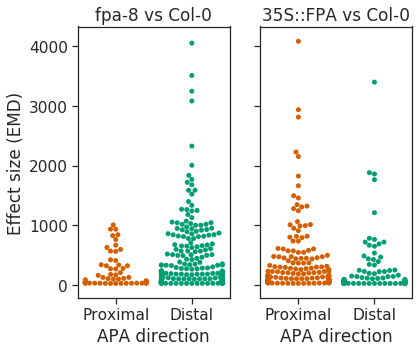

In [5]:
fpa_vs_col0_nanopore_drs = pd.read_csv(
    '../nanopore_apa_pipeline/pipeline/apa_results/fpa8_vs_col0.apa_results.bed',
    sep='\t',
    names=D3PENDR_RESULTS_COLUMNS,
)

FPAox_vs_col0_nanopore_drs = pd.read_csv(
    '../nanopore_apa_pipeline/pipeline/apa_results/35SFPA_vs_col0.apa_results.bed',
    sep='\t',
    names=D3PENDR_RESULTS_COLUMNS,
)

plot_reciprocal_histograms(
    [fpa_vs_col0_nanopore_drs, FPAox_vs_col0_nanopore_drs],
    ['fpa-8 vs Col-0', '35S::FPA vs Col-0',],
    [(-1000, 2000), (-2000, 1000)]
)
plt.savefig('figures/nanopore_histogram.svg')
plt.show()

plot_reciprocal_effect_sizes(
    [fpa_vs_col0_nanopore_drs, FPAox_vs_col0_nanopore_drs],
    ['fpa-8 vs Col-0', '35S::FPA vs Col-0',],
)
plt.savefig('figures/nanopore_swarmplot.svg')
plt.show()

In [18]:
fpa_distal = set(fpa_vs_col0_nanopore_drs.query('wass_fdr < 0.05 & wass_dist > 25 & wass_dir > 0').locus_id)
FPAox_proximal = set(FPAox_vs_col0_nanopore_drs.query('wass_fdr < 0.05 & wass_dist > 25 & wass_dir < 0').locus_id)
loci_tested = set(fpa_vs_col0_nanopore_drs.locus_id).intersection(FPAox_vs_col0_nanopore_drs.locus_id)
reciprocal = fpa_distal.intersection(FPAox_proximal)

print(
    len(reciprocal),
    len(loci_tested),
    len(fpa_distal.intersection(loci_tested)),
    len(FPAox_proximal.intersection(loci_tested)),
)

print(stats.hypergeom.sf(
    len(reciprocal) - 1,
    len(loci_tested),
    len(fpa_distal.intersection(loci_tested)),
    len(FPAox_proximal.intersection(loci_tested)),
))

16 9715 215 158
3.8836001200505515e-07


## Helicos DRS results:

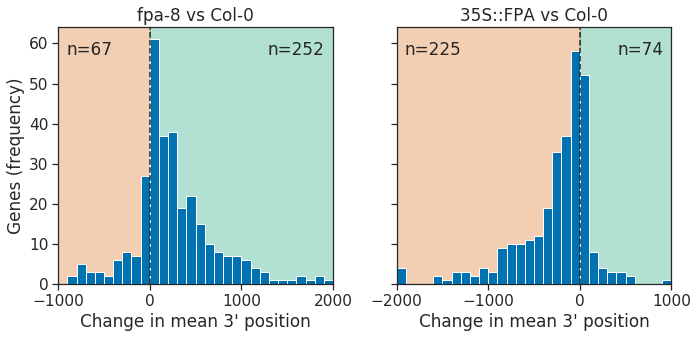

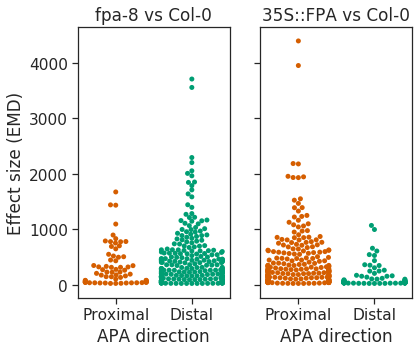

In [6]:
fpa_vs_col0_helicos_drs = pd.read_csv(
    '../helicos_apa_pipeline/pipeline/apa_results/fpa8_vs_col0.apa_results.bed',
    sep='\t',
    names=D3PENDR_RESULTS_COLUMNS,
)

FPAox_vs_col0_helicos_drs = pd.read_csv(
    '../helicos_apa_pipeline/pipeline/apa_results/35SFPA_vs_col0.apa_results.bed',
    sep='\t',
    names=D3PENDR_RESULTS_COLUMNS,
)

plot_reciprocal_histograms(
    [fpa_vs_col0_helicos_drs, FPAox_vs_col0_helicos_drs],
    ['fpa-8 vs Col-0', '35S::FPA vs Col-0',],
    [(-1000, 2000), (-2000, 1000)]
)
plt.savefig('figures/helicos_histogram.svg')
plt.show()

plot_reciprocal_effect_sizes(
    [fpa_vs_col0_helicos_drs, FPAox_vs_col0_helicos_drs],
    ['fpa-8 vs Col-0', '35S::FPA vs Col-0',],
)
plt.savefig('figures/helicos_swarmplot.svg')
plt.show()

In [21]:
fpa_distal = set(fpa_vs_col0_helicos_drs.query('wass_fdr < 0.05 & wass_dist > 25 & wass_dir > 0').locus_id)
FPAox_proximal = set(FPAox_vs_col0_helicos_drs.query('wass_fdr < 0.05 & wass_dist > 25 & wass_dir < 0').locus_id)
loci_tested = set(fpa_vs_col0_helicos_drs.locus_id).intersection(FPAox_vs_col0_helicos_drs.locus_id)
reciprocal = fpa_distal.intersection(FPAox_proximal)

print(
    len(reciprocal),
    len(loci_tested),
    len(fpa_distal.intersection(loci_tested)),
    len(FPAox_proximal.intersection(loci_tested)),
)

print(stats.hypergeom.sf(
    len(reciprocal) - 1,
    len(loci_tested),
    len(fpa_distal.intersection(loci_tested)),
    len(FPAox_proximal.intersection(loci_tested)),
))

44 11700 252 225
4.8438702437773604e-30


## Overlap:

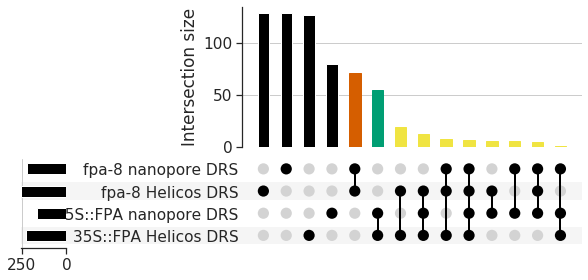

In [20]:
FPAox_helicos_sig = set(FPAox_vs_col0_helicos_drs.query('wass_fdr < 0.05 & wass_dist > 25 & wass_dir < 0').locus_id)
FPAox_nanopore_sig = set(FPAox_vs_col0_nanopore_drs.query('wass_fdr < 0.05 & wass_dist > 25 & wass_dir < 0').locus_id)
fpa_helicos_sig = set(fpa_vs_col0_helicos_drs.query('wass_fdr < 0.05 & wass_dist > 25 & wass_dir > 0').locus_id)
fpa_nanopore_sig = set(fpa_vs_col0_nanopore_drs.query('wass_fdr < 0.05 & wass_dist > 25 & wass_dir > 0').locus_id)

ups_data = from_contents({
    '35S::FPA Helicos DRS': FPAox_helicos_sig,
    '35S::FPA nanopore DRS': FPAox_nanopore_sig,
    'fpa-8 Helicos DRS': fpa_helicos_sig,
    'fpa-8 nanopore DRS': fpa_nanopore_sig,
})

ups = upsetplot(
    ups_data,
    sort_by='cardinality',
    sort_categories_by=None,
)
ups['intersections'].patches[4].set_color(pal[1])
ups['intersections'].patches[5].set_color(pal[2])
for p in ups['intersections'].patches[6:]:
    p.set_color(pal[3])
plt.savefig('figures/fpa_35SFPA_nanopore_helicos_upset.svg')
plt.show()

In [22]:
len(fpa_nanopore_sig.intersection(fpa_helicos_sig)), len(fpa_nanopore_sig.intersection(fpa_helicos_sig)) / len(fpa_nanopore_sig)

(88, 0.3963963963963964)

In [107]:
len(FPAox_nanopore_sig.intersection(FPAox_helicos_sig)), len(FPAox_nanopore_sig.intersection(FPAox_helicos_sig)) / len(FPAox_nanopore_sig)

(73, 0.4397590361445783)